# Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Portfolio/Projects/Course/Computer-Aided-Diagnosis-GI-Tract-Image-Segmentation')
!pwd

/content/drive/MyDrive/Portfolio/Projects/Course/Computer-Aided-Diagnosis-GI-Tract-Image-Segmentation


In [3]:
# Unzip files into the On the Fly Dataset
import zipfile
import os

zip_path = '/content/drive/MyDrive/Portfolio/Projects/Course/Computer-Aided-Diagnosis-GI-Tract-Image-Segmentation/datasets/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!


# Import Packages

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import animation, rc
import imageio
import time
import cv2
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow as tf
from skimage.morphology import label
import random
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.model_selection import StratifiedKFold
from skimage.segmentation import watershed
from skimage.measure import label
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A
import random
import pickle
import os
import collections
from sklearn.model_selection import train_test_split
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from tqdm import tqdm
import seaborn as sns
SEED = 42

In [5]:
# Fix randomness

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

fix_all_seeds(SEED)

# Config

In [6]:
PATH = '/content/datasets'
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
BATCH_SIZE = 2
NUM_EPOCHS = 3

WIDTH = 512
HEIGHT = 512

resize_factor = True
flip_prob = 0.2

# Normalize to resnet mean and std if True.
NORMALIZE = False

RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Changes the confidence required for a pixel to be kept for a mask.
cell_type_dict = {"stomach": 1, "large_bowel": 2, "small_bowel": 3}
idx_to_cell_type = {v: k for k, v in cell_type_dict.items()}
mask_threshold_dict = {1: 0.5, 2: 0.5, 3:  0.5}
min_score_dict = {1: 0.5, 2: 0.5, 3: 0.5}

# Use a StepLR scheduler if True.
USE_SCHEDULER = False

train_valid_ratio = 0.1

BOX_DETECTIONS_PER_IMG = 100

# Load Data

In [7]:
# load raw train data
raw_train_data = pd.read_csv('datasets/train.csv')
raw_train_data['case'] = raw_train_data['id'].apply(lambda x: x.split('_')[0])
raw_train_data['day'] = raw_train_data['id'].apply(lambda x: x.split('_')[1])
raw_train_data['slice'] = raw_train_data['id'].apply(lambda x: x.split('_')[2] + '_' + x.split('_')[3])
raw_train_data.head()

,id,class,segmentation,case,day,slice
0,case123_day20_slice_0001,large_bowel,NaN,case123,day20,slice_0001
1,case123_day20_slice_0001,small_bowel,NaN,case123,day20,slice_0001
2,case123_day20_slice_0001,stomach,NaN,case123,day20,slice_0001
3,case123_day20_slice_0002,large_bowel,NaN,case123,day20,slice_0002
4,case123_day20_slice_0002,small_bowel,NaN,case123,day20,slice_0002


In [8]:
# Create train/val/test split based on slice
temp = raw_train_data.groupby(['id','class']).agg({'segmentation':'count'}).reset_index().pivot_table(index = 'id', columns = 'class', values = 'segmentation').reset_index()
temp['all 3 organs'] = temp[['large_bowel','small_bowel','stomach']].sum(axis = 1)

df_images_train, df_images_temp = train_test_split(temp, stratify=temp['all 3 organs'],
                                                  test_size=0.35,
                                                  random_state=SEED)

df_images_val, df_images_test = train_test_split(df_images_temp, stratify=df_images_temp['all 3 organs'],
                                                  test_size=0.5714,
                                                  random_state=SEED) # test_size ~ 57.14% of 35%


df_train = raw_train_data[(raw_train_data['id'].isin(df_images_train['id'])) & (raw_train_data['segmentation'].notna())]
df_val = raw_train_data[(raw_train_data['id'].isin(df_images_val['id'])) & (raw_train_data['segmentation'].notna())]
df_test = raw_train_data[(raw_train_data['id'].isin(df_images_test['id'])) & (raw_train_data['segmentation'].notna())]

In [9]:
# # Create train/val/test split based on mask
# # Extract information from data
# from src.data import SegmentationDataset

# sd = SegmentationDataset(dataset_dir='/content/datasets/train',
#                          csv_file_path='/content/datasets/train.csv')
# df = sd.processed_df

# random.seed(42)

# # train - 65, val - 15, test - 20
# df_train, df_temp = train_test_split(df, test_size=0.35, random_state=42)
# df_val, df_test = train_test_split(df_temp, test_size=0.5714, random_state=42)  # test_size ~ 57.14% of 35%

# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

# Data Preparation

In [10]:
# # Dice Loss
# class DiceLoss(nn.Module):
#     def __init__(self, smooth=1):
#         super(DiceLoss, self).__init__()
#         self.smooth = smooth

#     def forward(self, y_pred, y_true):
#         y_pred = y_pred.contiguous().view(-1)
#         y_true = y_true.contiguous().view(-1)
#         intersection = (y_pred * y_true).sum()
#         dice = (2. * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
#         return 1 - dice

# # Combined BCE and Dice Loss
# class BCEDiceLoss(nn.Module):
#     def __init__(self, smooth=1):
#         super(BCEDiceLoss, self).__init__()
#         self.bce = nn.BCEWithLogitsLoss()
#         self.dice = DiceLoss(smooth)

#     def forward(self, y_pred, y_true):
#         bce_loss = self.bce(y_pred, y_true)
#         dice_loss = self.dice(y_pred, y_true)
#         return 0.5 * bce_loss + 0.5 * dice_loss

# def dice_coef_func(y_true, y_pred, smooth=1):
#     y_true_f = y_true.contiguous().view(-1)
#     y_pred_f = y_pred.contiguous().view(-1)
#     intersection = torch.sum(y_true_f * y_pred_f)
#     return (2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count

In [11]:
# Helper functions
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    masking = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        masking[mask>mask_threshold] = m
    return masking


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

In [12]:
#Metric: mean of the precision values at each IoU threshold
#Ref: https://www.kaggle.com/theoviel/competition-metric-map-iou

def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union

    return iou

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes IOU.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl, threshold_dict):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]

        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [13]:
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for train
    if train:
        transforms.append(HorizontalFlip(flip_prob))
        transforms.append(VerticalFlip(flip_prob))

    return Compose(transforms)

In [14]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, df, train_flag=None, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df
        self.train_flag = train_flag

        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)
        else:
            self.height = HEIGHT
            self.width = WIDTH

        self.image_info = collections.defaultdict(dict)

        df_temp = self.df.groupby(["id"])['segmentation'].agg(lambda x: list(x)).reset_index().merge(self.df.groupby(["id"])['class'].agg(lambda x: list(x)).reset_index(), how = 'left', on = 'id')

        for index, row in df_temp.iterrows():
            sample_id = row['id']
            case_num = sample_id.split('_')[0]
            day_num = sample_id.split('_')[1]
            slice_num = [x for x in os.listdir(f'/content/datasets/train/{case_num}/{case_num + "_" + day_num}/scans/') if sample_id.split('_')[3] in x.split('_')[1]][0]
            path = f'{self.image_dir}/train/{case_num}/{case_num + "_" + day_num}/scans/{slice_num}'
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': path,
                    'annotations': row["segmentation"],
                    'class': [cell_type_dict[x] for x in row["class"]]
                    }

    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''

        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        initial_HEIGHT = img.shape[0]
        initial_WIDTH = img.shape[1]

        if self.should_resize:
            img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (initial_HEIGHT, initial_WIDTH))

            if self.should_resize:
                a_mask = cv2.resize(a_mask, (self.width, self.height))

            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask

            boxes.append(self.get_box(a_mask))

        # labels
        labels = [int(info["class"][m]) for m in range(0, (n_objects))]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        if self.train_flag == 'train':
            # This is the required target for the Mask R-CNN
            target = {
                'boxes': boxes,
                'labels': labels,
                'masks': masks,
                'image_id': image_id,
                'area': area,
                'iscrowd': iscrowd
            }
        else:
            target = {
                'boxes': boxes,
                'labels': labels,
                'masks': masks,
                'image_id': image_id,
                'area': area,
                'iscrowd': iscrowd,
                'image_path':img_path,
                'initial_HEIGHT': initial_HEIGHT,
                'initial_WIDTH': initial_WIDTH
            }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [15]:
ds_train = ImageDataset(PATH, df_train, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=False))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

ds_val = ImageDataset(PATH, df_val, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                    num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

ds_test = ImageDataset(PATH, df_test, train_flag = 'train', resize=resize_factor, transforms=get_transform(train=False))
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True,
                     num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

image size used: 512 512
image size used: 512 512
image size used: 512 512


# Visualization

In [16]:
# Helper functions
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)
    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]

    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)

    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)

In [17]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def plot_image(image, target=None):
    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue

    fig, ax = plt.subplots()
    # Display the grayscale image
    ax.imshow((image)[0, :, :], cmap='gray')

    if target is not None:
        # Display masks
        for i in range(len(target['labels'])):
            if target['labels'][i] == 3: # Large Bowel
                ax.imshow(target['masks'][i, :, :], cmap=cmap1, alpha=0.5)
            elif target['labels'][i] == 2: # Small Bowl
                ax.imshow(target['masks'][i, :, :], cmap=cmap2, alpha=0.5)
            else: # Stomach
                ax.imshow(target['masks'][i, :, :], cmap=cmap3, alpha=0.5)

        # Create a legend for the masks
        red_patch = mpatches.Patch(color='red', label='Small Bowel')
        green_patch = mpatches.Patch(color='green', label='Large Bowel')
        blue_patch = mpatches.Patch(color='blue', label='Stomach')
        plt.legend(handles=[red_patch, green_patch, blue_patch])

    # Show the plot
    plt.show()

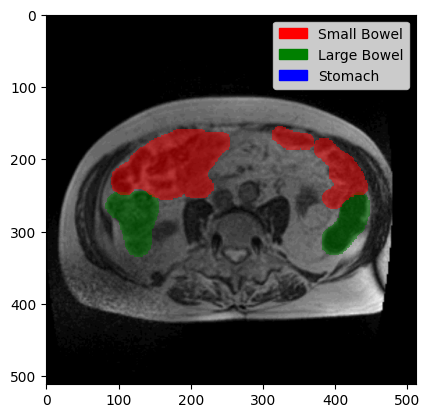

In [18]:
idx =100 # Change index to see different slice
image = ds_train[idx][0]
target = ds_train[idx][1]
plot_image(image, target)

In [19]:
# rc('animation', html='jshtml')

# def create_animation(ims):
#     print('# Images:', len(ims))
#     fig = plt.figure(figsize=(6, 6))
#     plt.axis('off')
#     im = plt.imshow(ims[0], cmap="gray")

#     def animate_func(i):
#         im.set_array(ims[i])
#         return [im]

#     return animation.FuncAnimation(fig, animate_func, frames = len(ims), interval = 1)

In [20]:
# # See images for a case number and day number
# case_num = 'case123'
# day_num = 'day0'
# list_images_data = []
# for images in os.listdir(f'/content/datasets/train/{case_num}/{case_num}_{day_num}/scans/'):
#     image_data = plt.imread(f'/content/datasets/train/{case_num}/{case_num}_{day_num}/scans/' + images)
#     list_images_data.append(image_data)
# create_animation(list_images_data)

# Modelling

## Model Loading

In [21]:
def get_model(num_classes, model_chkpt=None):
    # This is just a dummy value for the classification head

    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN,
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)

    if model_chkpt:
        model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))
    return model

In [38]:
# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS

# Initialize a new model or load a trained model for further training
e = 9

if e > 0:
    model_chk = f"mask-rcnn-trained/pytorch_model-e{e}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict), model_chk)
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)
else:
    model = get_model(len(cell_type_dict))
    model = model.to(DEVICE)

# Turn model into training mode
for param in model.parameters():
    param.requires_grad = True
model.train()

Loading: mask-rcnn-trained/pytorch_model-e9.bin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Model Training

In [23]:
TRAIN = True

In [39]:
if TRAIN:
    # Initialize
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Number of batches
    n_batches, n_batches_val = len(dl_train), len(dl_val)

    # Tract Loss
    epoch_nbr = []
    train_losses = []
    train_mask_losses = []
    val_losses = []
    val_mask_losses = []

    for epoch in range(1, NUM_EPOCHS + 1):
        # Set to train mode
        model.train()

        print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
        epoch_nbr.append(epoch)

        time_start = time.time()
        loss_accum = 0.0
        loss_mask_accum = 0.0

        for batch_idx, (images, targets) in enumerate(tqdm(dl_train), 1):
            # Predict
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            loss_accum += loss.item()
            loss_mask_accum += loss_dict['loss_mask'].item()

            if batch_idx % 500 == 0:
                print(f"[Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. {time.time() - time_start:.0f} secs")

        if USE_SCHEDULER:
            lr_scheduler.step()

        # Train losses
        train_loss = loss_accum / n_batches
        train_loss_mask = loss_mask_accum / n_batches

        # Store train losses
        train_losses.append(train_loss)
        train_mask_losses.append(train_loss_mask)

        # Validation
        val_loss_accum = 0
        val_loss_mask_accum = 0

        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(tqdm(dl_val), 1):  # Use tqdm here
                images = list(image.to(DEVICE) for image in images)
                targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

                val_loss_dict = model(images, targets)
                val_batch_loss = sum(loss for loss in val_loss_dict.values())
                val_loss_accum += val_batch_loss.item()
                val_loss_mask_accum += val_loss_dict['loss_mask'].item()

        # Validation losses
        val_loss = val_loss_accum / n_batches_val
        val_loss_mask = val_loss_mask_accum / n_batches_val
        elapsed = time.time() - time_start

        # Store validation losses
        val_losses.append(val_loss)
        val_mask_losses.append(val_loss_mask)

        # Save model
        torch.save(model.state_dict(), f"mask-rcnn-trained/pytorch_model-e{e + epoch}.bin")

        # Print result
        prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
        print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
        print(f"{prefix} Train mask loss: {train_loss_mask:7.3f}, Val mask loss: {val_loss_mask:7.3f}")

    # Export Losses
    losses = {
        'epoch_nbr': [e + epoch_idx for epoch_idx in epoch_nbr],
        'train_losses': train_losses,
        'train_mask_losses': train_mask_losses,
        'val_losses': val_losses,
        'val_mask_losses': val_mask_losses
    }
    df_losses = pd.DataFrame(losses)
    # Check existing file
    if os.path.isfile("output/mask_rcnn_losses.csv"):
        existing_df = pd.read_csv("output/mask_rcnn_losses.csv")
        df_losses = pd.concat([existing_df, df_losses], ignore_index=True)
        df_losses.to_csv("output/mask_rcnn_losses.csv", index=False)
    else:
        df_losses.to_csv("output/mask_rcnn_losses.csv", index=False)

Starting epoch 1 of 3


  0%|          | 0/5392 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  9%|▉         | 502/5392 [00:49<08:00, 10.19it/s]

[Batch 500 / 5392] Batch train loss:   0.199. 50 secs


 19%|█▊        | 1001/5392 [01:38<07:05, 10.32it/s]

[Batch 1000 / 5392] Batch train loss:   0.333. 99 secs


 28%|██▊       | 1502/5392 [02:27<06:14, 10.38it/s]

[Batch 1500 / 5392] Batch train loss:   0.201. 147 secs


 37%|███▋      | 2001/5392 [03:16<05:27, 10.34it/s]

[Batch 2000 / 5392] Batch train loss:   0.175. 197 secs


 46%|████▋     | 2500/5392 [04:05<04:46, 10.09it/s]

[Batch 2500 / 5392] Batch train loss:   0.297. 246 secs


 56%|█████▌    | 3000/5392 [04:55<03:54, 10.21it/s]

[Batch 3000 / 5392] Batch train loss:   0.406. 295 secs


 65%|██████▍   | 3501/5392 [05:44<03:04, 10.22it/s]

[Batch 3500 / 5392] Batch train loss:   0.435. 344 secs


 74%|███████▍  | 4002/5392 [06:33<02:13, 10.42it/s]

[Batch 4000 / 5392] Batch train loss:   0.228. 393 secs


 83%|████████▎ | 4501/5392 [07:22<01:26, 10.30it/s]

[Batch 4500 / 5392] Batch train loss:   0.504. 443 secs


 93%|█████████▎| 5001/5392 [08:12<00:39, 10.00it/s]

[Batch 5000 / 5392] Batch train loss:   0.220. 492 secs


100%|██████████| 1244/1244 [01:05<00:00, 19.13it/s]


[Epoch  1 /  3] Train loss:   0.342. Val loss:   0.414 [595 secs]
[Epoch  1 /  3] Train mask loss:   0.197, Val mask loss:   0.226
Starting epoch 2 of 3


  9%|▉         | 502/5392 [00:48<07:52, 10.34it/s]

[Batch 500 / 5392] Batch train loss:   0.427. 49 secs


 19%|█▊        | 1002/5392 [01:37<07:00, 10.45it/s]

[Batch 1000 / 5392] Batch train loss:   0.386. 97 secs


 28%|██▊       | 1501/5392 [02:25<06:32,  9.92it/s]

[Batch 1500 / 5392] Batch train loss:   0.338. 145 secs


 37%|███▋      | 2002/5392 [03:13<05:31, 10.23it/s]

[Batch 2000 / 5392] Batch train loss:   0.203. 194 secs


 46%|████▋     | 2501/5392 [04:02<04:38, 10.37it/s]

[Batch 2500 / 5392] Batch train loss:   0.220. 242 secs


 56%|█████▌    | 3001/5392 [04:50<03:50, 10.38it/s]

[Batch 3000 / 5392] Batch train loss:   0.376. 291 secs


 65%|██████▍   | 3501/5392 [05:38<03:03, 10.29it/s]

[Batch 3500 / 5392] Batch train loss:   0.204. 339 secs


 74%|███████▍  | 4001/5392 [06:26<02:12, 10.53it/s]

[Batch 4000 / 5392] Batch train loss:   0.370. 387 secs


 83%|████████▎ | 4501/5392 [07:14<01:25, 10.45it/s]

[Batch 4500 / 5392] Batch train loss:   0.459. 435 secs


 93%|█████████▎| 5001/5392 [08:03<00:39,  9.78it/s]

[Batch 5000 / 5392] Batch train loss:   0.216. 484 secs


100%|██████████| 1244/1244 [01:03<00:00, 19.72it/s]


[Epoch  2 /  3] Train loss:   0.333. Val loss:   0.407 [585 secs]
[Epoch  2 /  3] Train mask loss:   0.193, Val mask loss:   0.225
Starting epoch 3 of 3


  9%|▉         | 501/5392 [00:48<07:45, 10.50it/s]

[Batch 500 / 5392] Batch train loss:   0.230. 48 secs


 19%|█▊        | 1001/5392 [01:37<07:06, 10.29it/s]

[Batch 1000 / 5392] Batch train loss:   0.156. 97 secs


 28%|██▊       | 1502/5392 [02:25<06:07, 10.58it/s]

[Batch 1500 / 5392] Batch train loss:   0.242. 145 secs


 37%|███▋      | 2001/5392 [03:13<05:33, 10.18it/s]

[Batch 2000 / 5392] Batch train loss:   0.173. 194 secs


 46%|████▋     | 2502/5392 [04:02<04:38, 10.37it/s]

[Batch 2500 / 5392] Batch train loss:   0.287. 242 secs


 56%|█████▌    | 3002/5392 [04:51<03:48, 10.46it/s]

[Batch 3000 / 5392] Batch train loss:   0.235. 291 secs


 65%|██████▍   | 3502/5392 [05:38<03:03, 10.29it/s]

[Batch 3500 / 5392] Batch train loss:   0.209. 339 secs


 74%|███████▍  | 4002/5392 [06:27<02:10, 10.64it/s]

[Batch 4000 / 5392] Batch train loss:   0.380. 387 secs


 83%|████████▎ | 4501/5392 [07:15<01:24, 10.59it/s]

[Batch 4500 / 5392] Batch train loss:   0.361. 435 secs


 93%|█████████▎| 5001/5392 [08:03<00:39, 10.01it/s]

[Batch 5000 / 5392] Batch train loss:   0.378. 484 secs


100%|██████████| 1244/1244 [01:03<00:00, 19.61it/s]


[Epoch  3 /  3] Train loss:   0.323. Val loss:   0.414 [585 secs]
[Epoch  3 /  3] Train mask loss:   0.189, Val mask loss:   0.228


AttributeError: 'DataFrame' object has no attribute 'append'

## Visualize Training Process

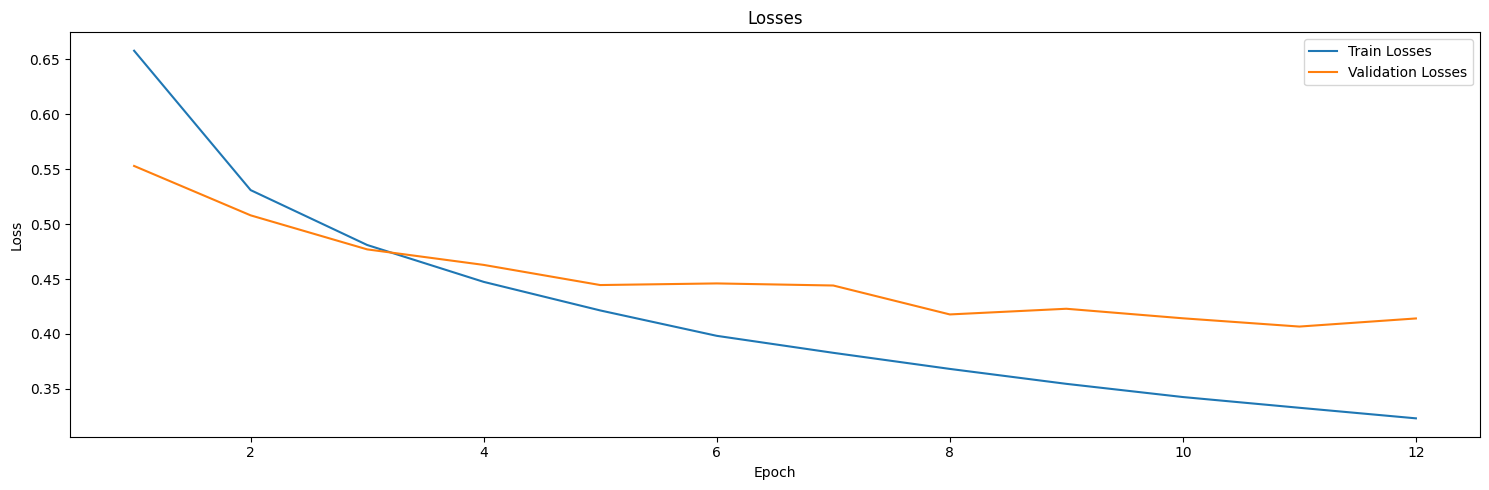

In [42]:
# Load the data
df_losses = pd.read_csv("output/mask_rcnn_losses.csv")

# Plotting
plt.figure(figsize=(15, 5))

# Total Losses Plot
plt.subplot(1, 1, 1)
sns.lineplot(data=df_losses, x='epoch_nbr', y='train_losses', label='Train Losses')
sns.lineplot(data=df_losses, x='epoch_nbr', y='val_losses', label='Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.tight_layout()
plt.show()

# Data & Model Preparation for Inference

In [43]:
# Load trained model
e = 12
model_chk = f"mask-rcnn-trained/pytorch_model-e{e}.bin"
print("Loading:", model_chk)
model = get_model(len(cell_type_dict), model_chk)
model.load_state_dict(torch.load(model_chk))
model = model.to(DEVICE)

Loading: mask-rcnn-trained/pytorch_model-e12.bin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [44]:
# Load data for inference
ds_train_inf = ImageDataset(PATH, df_train, train_flag = None, resize=resize_factor, transforms=get_transform(train=False))
ds_val_inf = ImageDataset(PATH, df_val, train_flag = None, resize=resize_factor, transforms=get_transform(train=False))
ds_test_inf = ImageDataset(PATH, df_test, train_flag = None, resize=resize_factor, transforms=get_transform(train=False))

image size used: 512 512
image size used: 512 512
image size used: 512 512


# Result Visualization

In [45]:
VISUALIZE_RESULTS = True

In [46]:
def compare_truth_pred(model, dataset, sample_index):
    # Froze model parameters and set it to evaluation mode
    for param in model.parameters():
        param.requires_grad = False

    model.eval();

    # Create custom colormaps for the masks
    cmap1 = ListedColormap(['none', 'red'])  # Mask 1 in red
    cmap2 = ListedColormap(['none', 'green'])  # Mask 2 in green
    cmap3 = ListedColormap(['none', 'blue'])  # Mask 3 in blue
    red_patch = mpatches.Patch(color='red', label='Small Bowel')
    green_patch = mpatches.Patch(color='green', label='Large Bowel')
    blue_patch = mpatches.Patch(color='blue', label='Stomach')

    # Retrieve the image and target (labels and masks) for the given index from the training dataset
    img, target = dataset[sample_index]
    image_id = target['image_id']  # ID of the image
    initial_HEIGHT = target['initial_HEIGHT']  # Original height of the image
    initial_WIDTH = target['initial_WIDTH']  # Original width of the image

    # Set up a matplotlib figure with three subplots to display the original image, ground truth, and predictions
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")

    # Plot original image
    ax[0].imshow(img[0,:,:], cmap = 'gray')
    ax[0].set_title(f"Original Image (Id:{sample_index})")
    ax[0].axis("off")

    # Plot ground truth masks
    ax[1].imshow(img[0,:,:], cmap = 'gray')
    ax[1].set_title(f"Ground Truth (Id:{sample_index})")
    ax[1].axis("off")

    # Display masks
    for i in range(len(target['labels'])):
        if target['labels'][i] == 3: # Large Bowel
            ax[1].imshow(target['masks'][i, :, :], cmap=cmap1, alpha=0.5)
        elif target['labels'][i] == 2: # Small Bowl
            ax[1].imshow(target['masks'][i, :, :], cmap=cmap2, alpha=0.5)
        else: # Stomach
            ax[1].imshow(target['masks'][i, :, :], cmap=cmap3, alpha=0.5)

    # Create a legend for the masks
    ax[1].legend(handles=[red_patch, green_patch, blue_patch])

    # Plot predicted masks
    ax[2].imshow(img[0,:,:], cmap = 'gray')
    ax[2].set_title(f"Predictions (Id:{sample_index})")
    ax[2].axis("off")

    # Set the model to evaluation mode to disable layers like dropout and batch normalization
    model.eval()
    with torch.no_grad():
        # Make predictions using the model
        preds = model([img.to(DEVICE)])[0]

    # Process results for each type of cell
    for cell_type in range(1, len(min_score_dict)+1):
        previous_masks = []  # List to store previous masks for overlap removal
        for i, mask in enumerate(preds["masks"]):
            # Filter out results with a score below the threshold
            score = preds["scores"][i].cpu().item()
            label = preds["labels"][i].cpu().item()
            if (score > min_score_dict[label]) and (label == cell_type):
                mask = mask.cpu().numpy()  # Convert mask to numpy array
                # Threshold mask to create binary mask
                binary_mask = mask > mask_threshold_dict[label]
                # Remove overlapping pixels
                binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
                previous_masks.append(binary_mask)

        # Flatten list of previous masks and create a binary mask for all cells of a type
        previous_masks = torch.tensor(np.array([item for sublist in previous_masks for item in sublist], dtype=int))
        binary_mask = np.zeros((HEIGHT, WIDTH))
        for m, mask in enumerate(previous_masks, 1):
            binary_mask[mask > 0.5] = 1

        # Display masks
        if cell_type == 3: # Large Bowel
            ax[2].imshow(binary_mask, cmap=cmap1, alpha=0.5)
        elif cell_type == 2: # Small Bowl
            ax[2].imshow(binary_mask, cmap=cmap2, alpha=0.5)
        else: # Stomach
            ax[2].imshow(binary_mask, cmap=cmap3, alpha=0.5)

    # Create a legend for the masks
    ax[2].legend(handles=[red_patch, green_patch, blue_patch])

    # Show the plot
    plt.show()

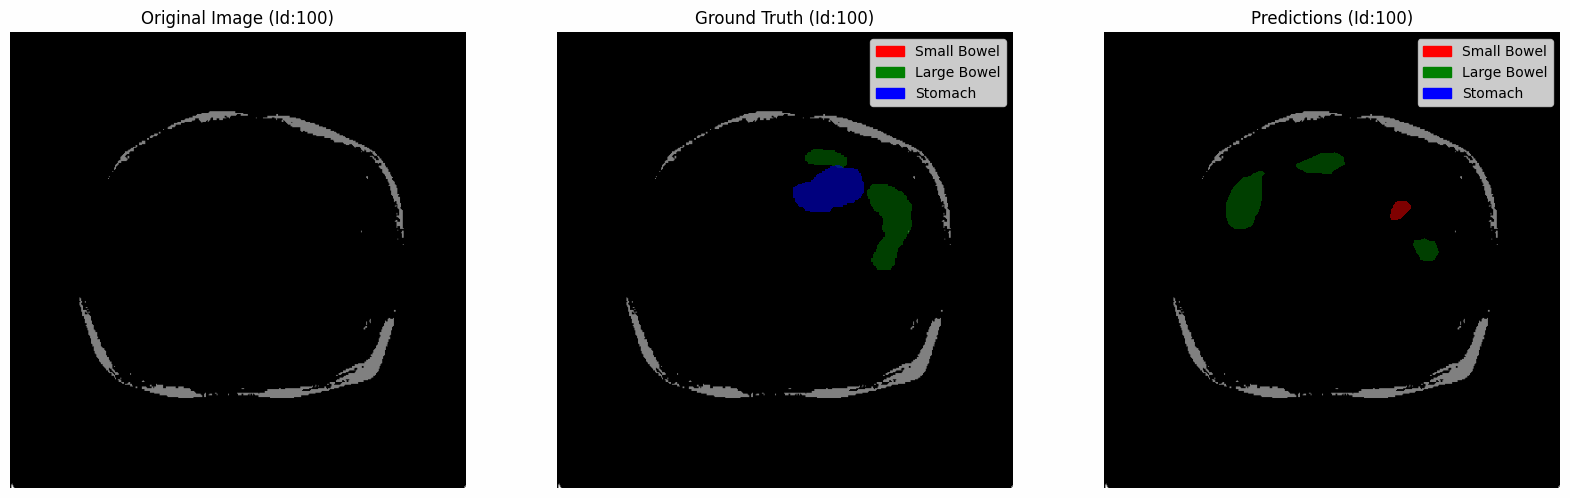

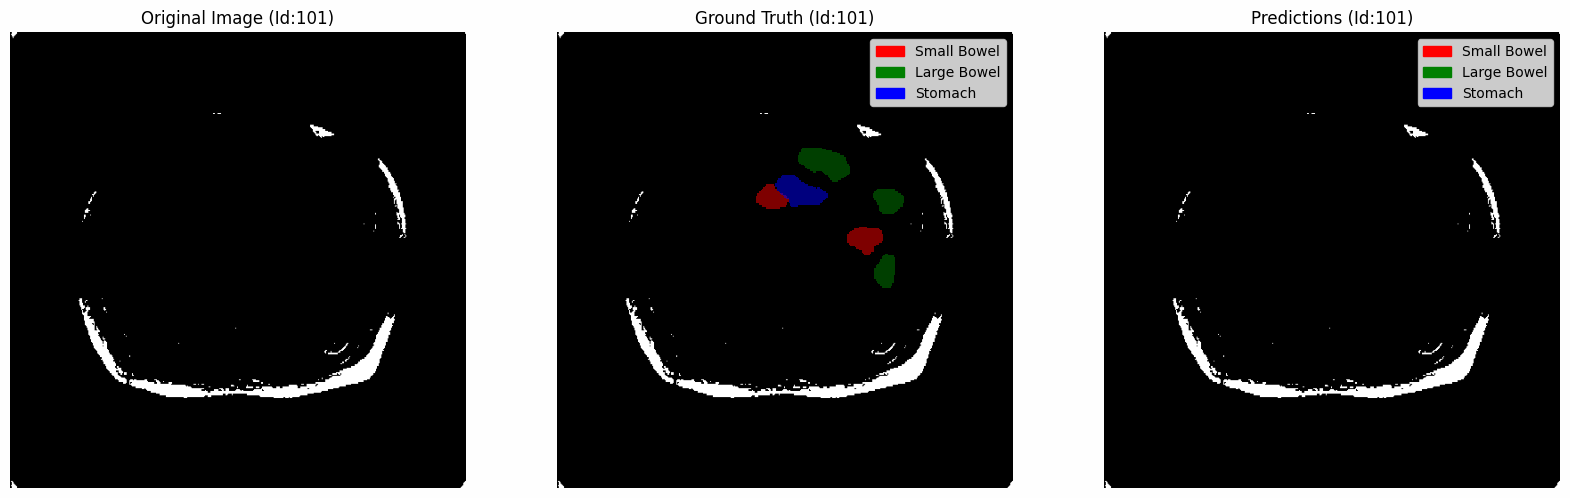

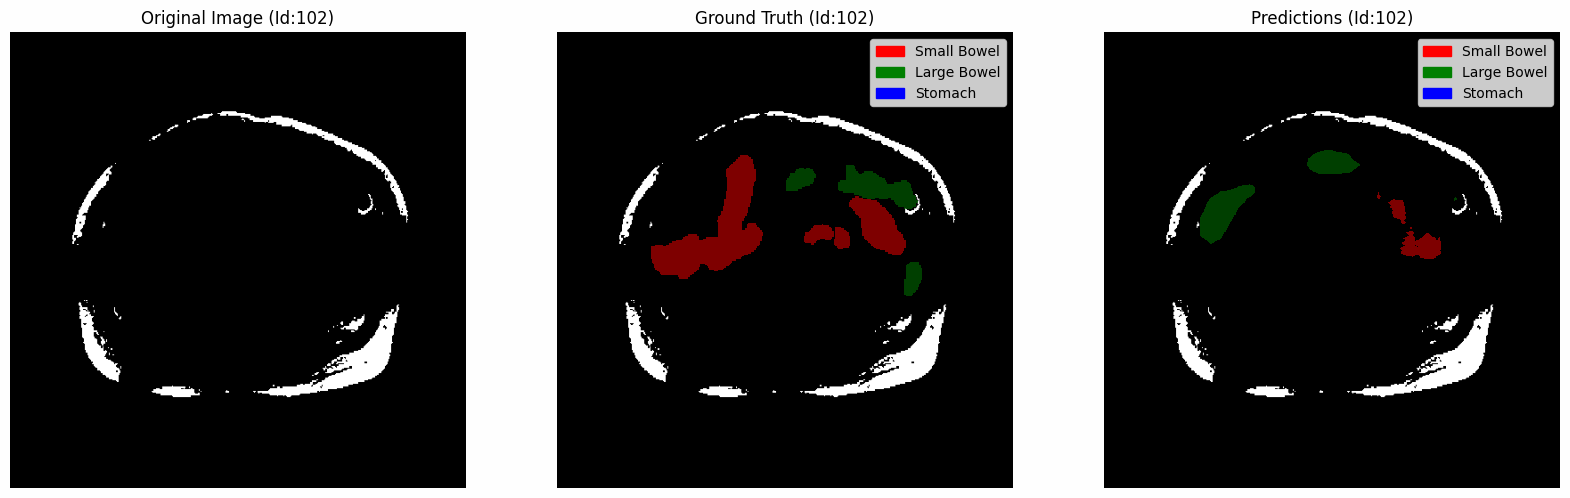

In [49]:
# Example usage:
for index in range(100, 103):
    compare_truth_pred(model, ds_val_inf, index)

# Inference

In [ ]:
INFERENCE = False

In [ ]:
def inference(model, dataset):
    # Froze model parameters and set it to evaluation mode
    for param in model.parameters():
        param.requires_grad = False

    model.eval();

    # Initialize a list to store prediction results
    predictions = []
    true_masks = []
    pred_masks = []

    # Iterate over the dataset using tqdm for progress bar visualization
    for num in tqdm(range(0, len(dataset))):
        # Retrieve the image for the current sample
        sample = dataset[num]
        img = sample[0]  # The image data
        image_id = sample[1]['image_id']  # ID of the image
        initial_HEIGHT = sample[1]['initial_HEIGHT']  # Original height of the image
        initial_WIDTH = sample[1]['initial_WIDTH']  # Original width of the image

        # Append masks
        true_masks.append(np.zeros((3, HEIGHT, WIDTH)))
        pred_masks.append(np.zeros((3, HEIGHT, WIDTH)))
        # Add ground truth masks to the list
        for i in range(len(sample[1]['labels'])):
            true_masks[num][sample[1]['labels'][i]-1, :, :] = sample[1]['masks'][i, :, :]


        # No gradient is needed for inference, thus wrap in torch.no_grad()
        with torch.no_grad():
            preds = model([img.to(DEVICE)])[0]  # Perform inference

        # Process predictions for each type of cell
        for cell_type in range(1, len(min_score_dict)+1):
            previous_masks = []  # List to store previous masks for overlap removal
            for i, mask in enumerate(preds["masks"]):
                # Filter out predictions with a score below the threshold
                score = preds["scores"][i].cpu().item()
                label = preds["labels"][i].cpu().item()
                if (score > min_score_dict[label]) and (label == cell_type):
                    mask = mask.cpu().numpy()  # Convert mask to numpy array
                    # Resize mask back to the original image dimensions
                    mask = cv2.resize(mask.reshape((HEIGHT, WIDTH, 1)), (initial_WIDTH, initial_HEIGHT))[None, :, :]
                    # Threshold mask to create binary mask
                    binary_mask = mask > mask_threshold_dict[label]
                    # Remove overlapping pixels
                    binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
                    previous_masks.append(binary_mask)

            # Flatten list of previous masks and create a binary mask for all cells of a type
            previous_masks = torch.tensor(np.array([item for sublist in previous_masks for item in sublist], dtype=int))
            binary_mask = np.zeros((initial_HEIGHT, initial_WIDTH))
            for m, mask in enumerate(previous_masks, 1):
                binary_mask[mask > 0.5] = 1
            # Encode the binary mask using run-length encoding
            rle = rle_encoding(binary_mask)
            # Append the prediction (image ID, cell type, and RLE)
            predictions.append((image_id, {v: k for k, v in cell_type_dict.items()}[cell_type], rle))
            # Add the predicted mask to the list
            binary_mask_resized = cv2.resize(binary_mask, (HEIGHT, WIDTH), interpolation=cv2.INTER_NEAREST)
            pred_masks[num][cell_type-1, :, :] = binary_mask_resized[:, :]

        # Add empty prediction if no RLE was generated for this image
        all_image_ids = [image_id for image_id, _, _ in predictions]
        if image_id not in all_image_ids:
            for key in cell_type_dict.keys():
                predictions.append((image_id, key, ""))

    # Convert predictions to DataFrame
    df_preds = pd.DataFrame(predictions, columns=['id', 'class', 'predicted'])

    return df_preds, true_masks, pred_masks

In [ ]:
if INFERENCE:
    # Make predictions
    # df_preds_train, true_masks_train, pred_masks_train = inference(model, ds_train_inf)
    df_preds_val, true_masks_val, pred_masks_val = inference(model, ds_val_inf)
    # df_preds_test, true_masks_test, pred_masks_test = inference(model, ds_test_inf)

    # df_preds_train.to_csv("output/maskrcnn_preds_train.csv", index=False)
    df_preds_val.to_csv(f"output/maskrcnn_preds_val.csv", index=False)
    # df_preds_test.to_csv("output/maskrcnn_preds_test.csv", index=False)

    display(df_preds_val.head())

    # Calculate IoU for three categories
    iou_stomach = iou_map([mask[0, :, :] for mask in true_masks_val], [mask[0, :, :] for mask in pred_masks_val])
    iou_large_bowel = iou_map([mask[1, :, :] for mask in true_masks_val], [mask[1, :, :] for mask in pred_masks_val])
    iou_small_bowel = iou_map([mask[2, :, :] for mask in true_masks_val], [mask[2, :, :] for mask in pred_masks_val])
    print(f"Stomach IoU: {iou_stomach}")
    print(f"Large Bowel IoU: {iou_large_bowel}")
    print(f"Small Bowel IoU: {iou_small_bowel}")

# Find Best Threshold

In [ ]:
FIND_THRESHOLD = False

In [ ]:
# Find best threshold based on validation dataset for each organ
if FIND_THRESHOLD:
  valid_data_threshold_analysis = pd.DataFrame(data = None, columns = ['stomach', 'large_bowel', 'small_bowel', 'IoU'])
  i = 0
  for stomach_prob in tqdm(range(45, 55, 5), desc='Stomach Probabilities'):
      for large_bowel_prob in range(45, 55, 5):
          for small_bowel_prob in range(45, 55, 5):
              mask_threshold_dict = {1: stomach_prob / 100, 2: large_bowel_prob / 100, 3: small_bowel_prob / 100}
              valid_data_threshold_analysis.loc[i] = stomach_prob / 100, large_bowel_prob / 100, small_bowel_prob / 100, get_score(ds_val, model, mask_threshold_dict)
              i += 1
  valid_data_threshold_analysis